In [19]:
import numpy as np
import time
import multiprocessing
import matplotlib.pyplot as plt

class OscGenProcess:
    def __init__(self, amplitude, frequency, phase_shift, duration=None):
        self.amplitude = amplitude
        self.frequency = frequency
        self.phase_shift = phase_shift
        self.duration = duration

        # Initializing manager and shared lists correctly
        manager = multiprocessing.Manager()
        self.times = manager.list()
        self.outputs = manager.list()

        # Event for controlling the indefinite run
        self.stop_event = manager.Event()

    def generate_sine_wave(self):
        period = 1 / self.frequency
        interval = period / 10
        start_time = time.time()
        max_list_size = 50000  # Maximum number of elements in the list

        if self.duration is not None:
            end_time = start_time + self.duration

        while not self.stop_event.is_set() and (self.duration is None or time.time() < end_time):
            current_time = time.time() - start_time
            omega = 2 * np.pi * self.frequency
            y = self.amplitude * np.sin(omega * current_time + self.phase_shift)

            # Ensure list does not exceed the maximum size
            if len(self.times) >= max_list_size:
                # Remove the oldest item
                self.times.pop(0)
                self.outputs.pop(0)

            # Append current time and output to the lists
            self.times.append(current_time * 1000)  # Convert time to milliseconds
            self.outputs.append(y)
        
            time.sleep(interval)

    def run(self):
        self.process = multiprocessing.Process(target=self.generate_sine_wave)
        self.process.start()

    def stop(self):
        self.stop_event.set()
        self.process.join()

    def plot_results(self):
        plt.figure(figsize=(10, 4))
        plt.plot(list(self.times), list(self.outputs), label='Sine Wave')  # Convert Manager list to regular list
        plt.title('Sine Wave Output Over Time')
        plt.xlabel('Time (milliseconds)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.legend()
        plt.show()

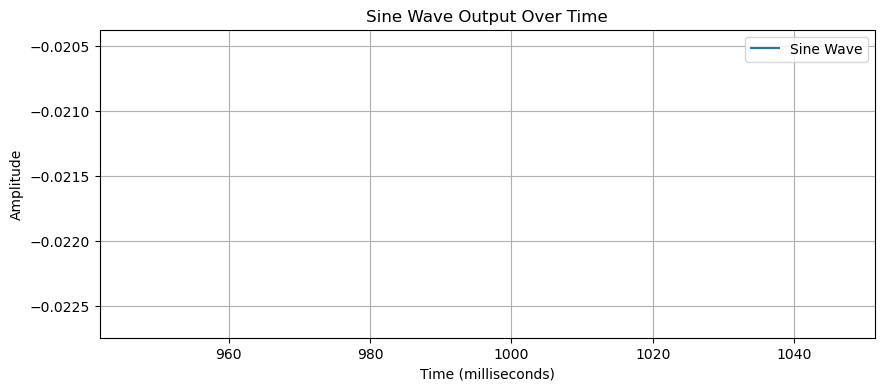

Finished generating the sine wave.


In [22]:
# Example usage

if __name__ == '__main__':
    oscillator = OscGenProcess(amplitude=1, frequency=1, phase_shift=0)
    oscillator.run()  # Start generating in a separate process
    time.sleep(1)  # Let it run for 2 seconds
    oscillator.stop()  # Stop the generation
    oscillator.plot_results()
    print("Finished generating the sine wave.")